In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns

In [8]:
# Load the dataset
df_ben_ddos = pd.read_csv('df_ben_ddos.csv')
df_ben_ddos

,id.orig_addr,id.orig_port,id.resp_haddr,id.resp_pport,proto_enum,duration_interval,conn_state_string,orig_pkts_count,orig_ip_bytes_count,resp_pkts_count,resp_bytes,Category
0,1098,48438,12963,23,1,5.030600,4,1,60,0,0,0
1,1098,33878,59500,23,1,3.089012,4,3,180,0,0,0
2,1098,55416,62742,23,1,3.089276,4,3,180,0,0,0
3,1098,47778,11680,23,1,5.030600,4,1,60,0,0,0
4,1098,46752,1504,23,1,3.130498,4,3,180,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2314090,1097,59699,22203,62336,1,5.030600,0,0,0,0,0,1
2314091,1097,32909,22203,62336,1,5.030600,0,0,0,0,0,1
2314092,1097,25120,22203,62336,1,5.030600,0,0,0,0,0,1
2314093,1097,30340,22203,62336,1,5.030600,0,0,0,0,0,1


In [9]:
# Sampled dataset, it could be either random rows or 10k from beningn and 10k from malicious to balance the trained dataset
#df_sampled = df_ben_ddos.sample(frac=0.01, random_state=42)
df_first = df_ben_ddos[:70000].sample(n=50000, random_state=42)
df_last = df_ben_ddos[80000:].sample(n=50000, random_state=42)
df_sampled = pd.concat([df_first, df_last])
df_sampled

# min_values = []
# max_values = []
# for col in df_sampled:
#
#     min_values.append(min(df_sampled[col]))
#     max_values.append(max(df_sampled[col]))
#
# print(min_values)
# print(max_values)

,id.orig_addr,id.orig_port,id.resp_haddr,id.resp_pport,proto_enum,duration_interval,conn_state_string,orig_pkts_count,orig_ip_bytes_count,resp_pkts_count,resp_bytes,Category
46730,1227,5151,6991,53,2,5.030600,4,1,540,0,0,0
48393,1227,61215,51455,53,2,5.030600,4,1,540,0,0,0
41416,1227,60587,64840,53,2,5.030600,4,1,540,0,0,0
34506,1098,52092,10766,23,1,3.119981,4,3,180,0,0,0
43725,1227,5566,41839,53,2,5.030600,4,1,540,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
301298,1098,6627,37595,80,1,4.591175,3,2,80,0,0,1
2294362,1097,25797,22203,62336,1,5.030600,0,0,0,0,0,1
926346,1098,20778,37595,22,1,95.031517,0,62,3100,0,0,1
626152,1098,26001,37595,80,1,4.856502,3,4,160,0,0,1


In [10]:
# Separate features and target labels
X = df_sampled.drop(columns=['Category', 'id.resp_haddr', 'id.resp_pport', 'proto_enum', 'conn_state_string', 'resp_pkts_count', 'resp_bytes'])
y = df_sampled['Category']
X

,id.orig_addr,id.orig_port,duration_interval,orig_pkts_count,orig_ip_bytes_count
46730,1227,5151,5.030600,1,540
48393,1227,61215,5.030600,1,540
41416,1227,60587,5.030600,1,540
34506,1098,52092,3.119981,3,180
43725,1227,5566,5.030600,1,540
...,...,...,...,...,...
301298,1098,6627,4.591175,2,80
2294362,1097,25797,5.030600,0,0
926346,1098,20778,95.031517,62,3100
626152,1098,26001,4.856502,4,160


In [11]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [12]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [13]:
# Define the neural network with stronger regularization and dropout
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.01)),  # Stronger L2 regularization
    Dropout(0.5),  # Increased dropout
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification output
])

C:\Users\usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
# Compile the model
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [15]:
# Add early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [16]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,  # Increase the number of epochs since early stopping is applied
    batch_size=64,
    callbacks=[early_stopping],  # Stop training when validation loss stops improving
    verbose=1
)


Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7770 - loss: 0.6939 - val_accuracy: 0.9750 - val_loss: 0.3463
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9505 - loss: 0.3483 - val_accuracy: 0.9823 - val_loss: 0.2620
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9700 - loss: 0.2808 - val_accuracy: 0.9922 - val_loss: 0.2232
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9758 - loss: 0.2441 - val_accuracy: 0.9894 - val_loss: 0.1943
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9774 - loss: 0.2183 - val_accuracy: 0.9924 - val_loss: 0.1751
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9800 - loss: 0.1960 - val_accuracy: 0.9894 - val_loss: 0.1620
Epoch 7/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9820 - loss: 0.1800 - val_accuracy: 0.9898 - val_loss: 0.1470
Epoch 8/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9822 - loss: 0

In [11]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - accuracy: 0.9967 - loss: 0.0583
Test Loss: 0.05758954584598541
Test Accuracy: 0.996999979019165


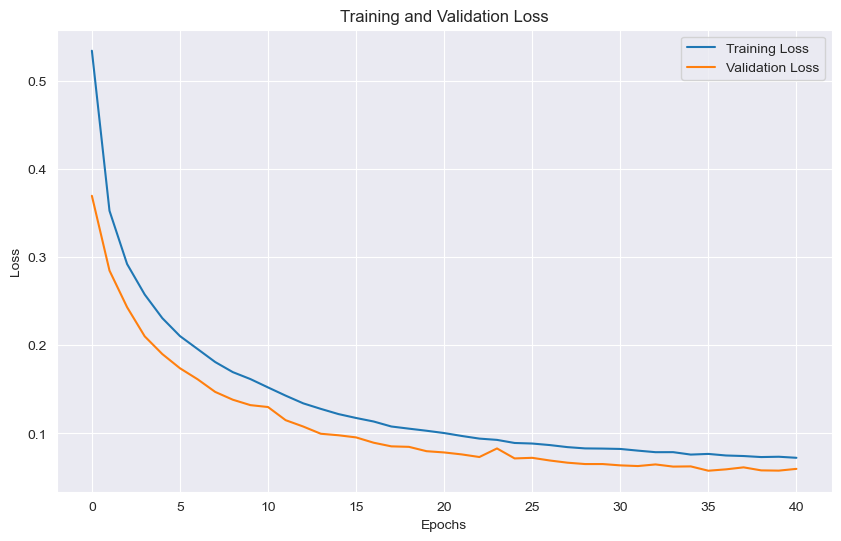

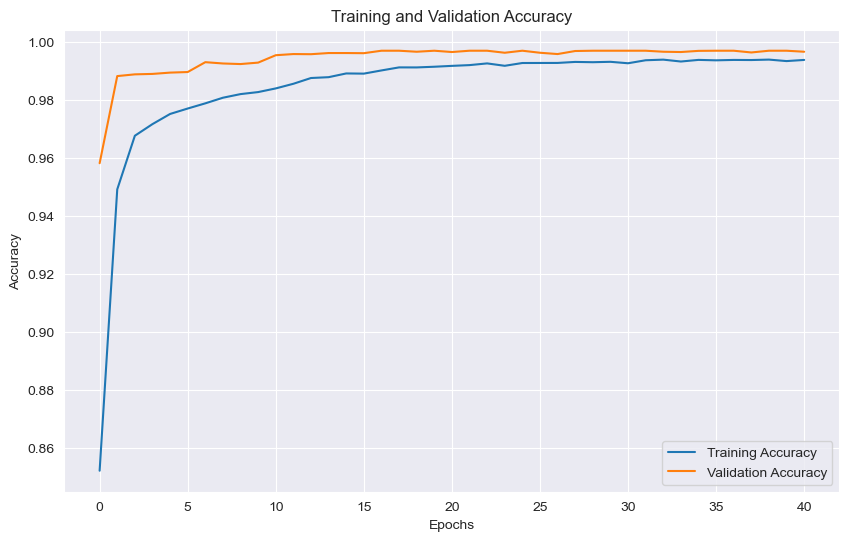

In [12]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
# Predict on the test set
y_pred = (model.predict(X_test) > 0.5).astype(int)  # Threshold of 0.5 for binary classification

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step


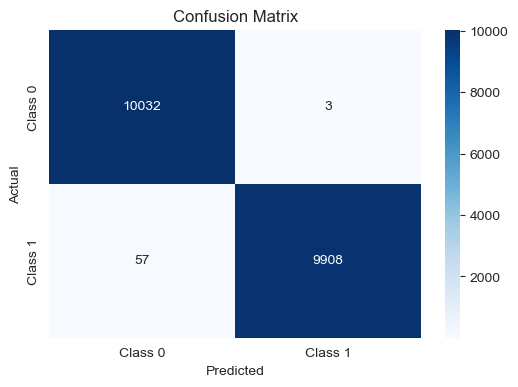

In [14]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [15]:
# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, model.predict(X_test))
print(f"ROC-AUC Score: {roc_auc:.2f}")
model.save('nn.h5')

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.99      1.00      1.00     10035
     Class 1       1.00      0.99      1.00      9965

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step


ROC-AUC Score: 1.00


In [50]:
import ipaddress
import tensorflow as tf
from keras import layers as l, models as m
import numpy as np

NOISE_DIM = 100
COLUMNS = 5

# id.orig_addr	id.orig_port	id.resp_haddr	id.resp_pport	proto_enum	duration_interval	conn_state_string	orig_pkts_count	orig_ip_bytes_count	resp_pkts_count	resp_bytes
min_values = []
max_values = []
# X = id.orig_addr	id.orig_port	duration_interval	orig_pkts_count	orig_ip_bytes_count
for col in X:

    min_values.append(min(X[col]))
    max_values.append(max(X[col]))

array1 = np.array(min_values)
array2 = np.array(max_values)
# print(min_values)
# print(max_values)

# Features that will be used in the generator
modifiable_features = ['id.orig_addr', 'id.orig_port', 'duration_interval', 'orig_pkts_count', 'orig_ip_bytes_count']

# Features which values will remain fixed
fixed_features = ['id.resp_haddr', 'id.resp_pport', 'proto_enum', 'conn_state_string', 'resp_pkts_count', 'resp_bytes']

# Extract the features from the dataset
X_modifiable = X[:5]
X_fixed = X[5:]

def make_generator_model():
    model = m.Sequential([
        l.Input(shape=(NOISE_DIM,)),
        l.Dense(64, activation='relu'),
        l.Dense(32, activation='relu'),
        l.Dense(COLUMNS, activation='tanh')
    ])

    return model


BATCH_SIZE = 256

cross_entropy = tf.keras.losses.BinaryCrossentropy()
generator_optimizer = tf.keras.optimizers.Adam(1e-4)

EPOCHS = 500

generator = make_generator_model()
discriminator = tf.keras.models.load_model('nn.h5')

@tf.function
def train_step():
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape:
        generated_flows = generator(noise, training=True)
        fake_output = discriminator(generated_flows, training=False)
        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))



def denormalize_min_max(normalized_data):
    denormalized_data = ((normalized_data + 1) / 2) * (array2 - array1) + array1
    denormalized_data = [round(val) for val in denormalized_data]
    denormalized_data[0] = str(ipaddress.IPv4Address(denormalized_data[0]))
    return denormalized_data

def get_trained_gan():
    # Initialize a list to store the denormalized flows
    denormalized_flows = []

    for epoch in range(EPOCHS):
        train_step()

        seed = tf.random.normal([1, NOISE_DIM])
        flow = generator(seed, training=False)

        # Denormalize the flow
        denormalized_flow = denormalize_min_max(flow[0].numpy())
        # 'id.resp_haddr' this is the most repeated value 52879
        d = str(ipaddress.IPv4Address(round(((52879 + 1) / 2) * (65272 - 0) + 0)))
        denormalized_flow.append(d)
        # 'id.resp_pport' is the most repeated port
        denormalized_flow.append(80)
        # 'proto_enum' most repeated
        denormalized_flow.append(1)
        # 'conn_state_string' mean is 3
        denormalized_flow.append(3)
        # 'resp_pkts_count' mean is 0.003
        denormalized_flow.append(0)
        # 'resp_bytes' mean is 2.28
        denormalized_flow.append(2)
       

        # Append the denormalized flow to the list
        denormalized_flows.append(denormalized_flow)

        predicted = discriminator.predict(flow)
        print(f"Denormalised Flow {denormalized_flow}, {predicted}")

        # Optionally, print in a more readable format
        # formatted_flow = [f"{num:.2f}" for num in denormalized_flow]
        # print(f"Denormalized Flow {formatted_flow}, {predicted}")

    # Convert the list of denormalized flows into a DataFrame
    df = pd.DataFrame(denormalized_flows, columns=modifiable_features)

    # Export the DataFrame to CSV
    df.to_csv("denormalized_flows.csv")

    return generator, discriminator

# Train the GAN
generator, discriminator = get_trained_gan()

# Generate adversarial samples
noise = tf.random.normal([len(X_test), NOISE_DIM])
adversarial_samples = generator(noise, training=False)

X


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Denormalised Flow ['0.0.7.102', 25996, 23, 19, 1928, '102.221.125.192', 80, 1, 3, 0, 2], [[1.7619182e-05]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Denormalised Flow ['0.0.6.176', 51137, 19, 28, 417, '102.221.125.192', 80, 1, 3, 0, 2], [[1.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Denormalised Flow ['0.0.10.217', 33991, 7, 18, 3088, '102.221.125.192', 80, 1, 3, 0, 2], [[2.388274e-08]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Denormalised Flow ['0.0.9.100', 27084, 24, 7, 4067, '102.221.125.192', 80, 1, 3, 0, 2], [[2.2164725e-06]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Denormalised Flow ['0.0.4.106', 42624, 12, 46, 2077, '102.221.125.192', 80, 1, 3, 0, 2], [[0.00417127]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Denormalised Flow ['0.0.9.145', 36514, 22, 26, 3371, '102.221.125.192', 80, 1, 3, 0, 2], [[1.1378173e-06]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Denormalised Flow ['0.0.3.240', 46859, 91, 20, 3881, '102.221.125.192', 80, 1, 3, 0, 2], [[0.45647928]]
1/

ValueError: 5 columns passed, passed data had 11 columns

In [29]:
import matplotlib.pyplot as plt

# Assuming adversarial_samples is a 1D array or list
plt.plot(adversarial_samples, label='Adversarial Samples')
plt.title('Adversarial Samples Generated')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()


# Evaluate classifier's performance on adversarial samples
predictions_on_adversarial = discriminator.predict(adversarial_samples)
print("Predictions on adversarial examples (discriminator output):", predictions_on_adversarial[0])

# To check detection evasion success:
# If the discriminator is predicting "real" (output near 1) for adversarial examples,
# then the detection evasion is successful.

# You can also compare the classifier's performance on original vs adversarial samples:
# Original test accuracy
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

original_predictions = discriminator.predict(X_test)
original_accuracy = (original_predictions >= 0.5).mean()
print(f"Original accuracy: {original_accuracy:.4f}")

test_loss, test_accuracy = discriminator.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Adversarial test accuracy
adversarial_accuracy = (predictions_on_adversarial >= 0.5).mean()
print(f"Adversarial accuracy: {adversarial_accuracy:.4f}")
X

NameError: name 'adversarial_samples' is not defined

In [33]:
import pandas as pd

# Load the CSV file
csv_file = "flows.csv"
data = pd.read_csv(csv_file)  # Skip the first row if it contains metadata
data

selected_features = ['sa', 'sp', 'td', 'ipkt', 'ibyt']
X = data[selected_features]
X['sa'] = X['sa'].map(lambda ip: int(ipaddress.IPv4Address(ip)))

model.predict(X)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/var/folders/nj/scyrvwln431b58h3d50x1v600000gn/T/ipykernel_20943/354701489.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['sa'] = X['sa'].map(lambda ip: int(ipaddress.IPv4Address(ip)))


array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],